In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import IPython

## so-vits-svc
#### This notebook only for preprocessing, we will use Google Drive to run the training.

In this project we will train a deep learning voice changing model that specialized for singing. It is not a project that from Kaggle or other deep learning database, we will collect our own data. Also, so-vits-svc has gone through several updates, it is very complicated, we will use the basic code from GitHub, and do the find tuning. The main difficulty of this project is to collect data and pre-process data, and to introduce how to train so-vits-svc. 

Since this model require more than 10GB of VRAM, we will train is in Google Cloud. Here, we will only view the training data. https://colab.research.google.com/github/voicepaw/so-vits-svc-fork/blob/main/notebooks/so-vits-svc-fork-4.0.ipynb

### Model 
The model and training process are long, and the code is from GitHub, so we will train it in other notebook. This section just a brief summary of the model.

VITS is mainly a VAE model, but have GAN and flow involve. To train the model, we need the voice slice and corresponding text. We convert our voice to linear spectrogram, pass it into our encoder decoder model, and get the output as waveform. To minimize the loss of decoder, we will use GAN. To train the encoder, the loss will be the KL divergence between the output from encoder and the projection of text phonemes. 

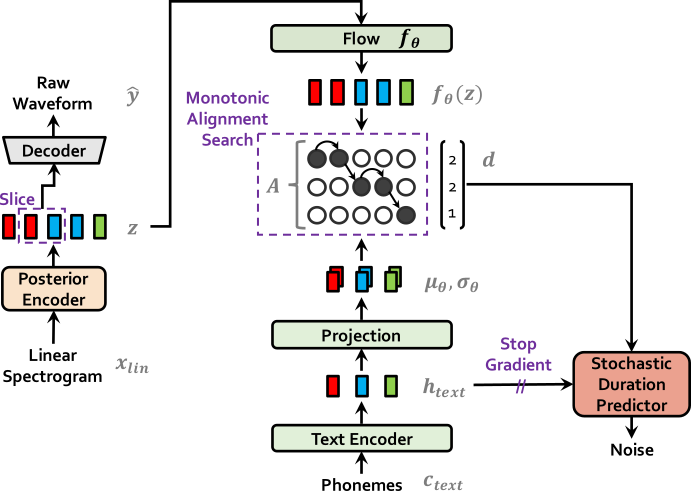

In [2]:
train_vits = 'sample/vits_model.png'
Image.open(train_vits)

For inference, we will replace the z from encoder with the text projection, pass it into the decoder and get our waveform. The flow in between allow us to pass our data in either direction. 

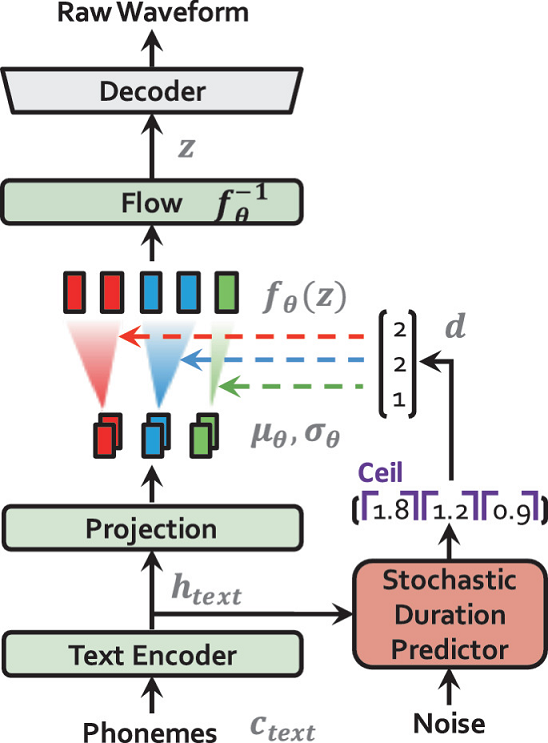

In [3]:
inference_vits = 'sample/vits_inference.png'
Image.open(inference_vits)

We chose VITS over VAE or GAN because the training process for Gan can be very unstable and difficult to debug, and it can produce good speech very quickly, but we don't have specific control over it to produce the desired speech. However, the samples generated by VAE may be fuzzy and of low quality, and the training process involves complex mathematical calculations, which increases the difficulty of training. VITS combines the advantages of both models, using the antagonism of GAN, to generate very realistic speech, and the addition of VAE can control the output we want. Although there are variant models with less VITS, we will only use the most basic VITS model for this project because of the large amount of computation required.

## Data
This time we used data from the game, the format is mp3, there are 82 voice, each voice length is different, from the shortest 5s to the longest 25s, and there may be multiple pauses in a voice. So we're going to use software to split the pauses into 205 voice segments, around 5 seconds each. The short speech ensures that the model does not take too long to learn one speech. Then we will reduce the noise of the speech and remove the background sound effects, so that the model can better learn the characteristics of the voice.
The detailed method and introduction are in the presentation jupyter notebook.

### Pre-processing
If you not download the audio source file, you may not play the mp3, you can watch the video to listen the audio.
#### denoising
The raw voice usually contain some noise or background music, those noise affect our model, we need to extract the human voice. We will use the app from online. https://vocalremover.org/. Here is the voice after preprocessing.

In [4]:
# sample of raw voice
IPython.display.display(IPython.display.Audio("sample/sound_with_rain.mp3"))

# sample of voice after noise reduction
IPython.display.display(IPython.display.Audio("sample/sound_with_rain_vocals.mp3"))


#### extracting human voice from song
Because this model is for singing changing, we may use the voice from singer, and we want to extract the voice from their song, we can use some App to help us retains only the human voice.

In [5]:
# singing
IPython.display.display(IPython.display.Audio("sample/song.mp3"))

# human voice only
IPython.display.display(IPython.display.Audio("sample/song_vocals.mp3"))


#### sound slice
In normally speech, there are pauses. We need to remove all the silence, and cut those voices into small pieces. We want our voice less than 10s, so the training will be easier. We will use 'audiosplitter' to help us. You can download the audiosplitter in https://github.com/JarodMica/audiosplitter

In [6]:
# voice less than 10s
# let's listen the final pre-processing training data
IPython.display.display(IPython.display.Audio("sample/slice.wav"))

#### stretched voice
Sometimes the pauses between sentences maybe too long, and there are certain stretched voice, those can cause the model to learn the wrong pronunciation. In this case, we have two ways to deal with it, for the gap between sentences is too long, we will divide into two sentences, and for stretched voice, we will delete this sentence.

In [7]:
IPython.display.display(IPython.display.Audio("sample/stretched.mp3"))

#### Voice to phonemes
In order to train the model, we also need the phonemes for each voice. For English, it is easy, we can use text-to-speech software. But, if we want to train our model in other language, which is our case, we need to type the corresponding language and convert to phonemes. Our model can convert the text to phoneme, so we only need to recode the voice text into a txt file.

I could not submit two .ipynb file, so I will move some data description from my code file

In [8]:
from PIL import Image
Image.open('sample/number_of_raw_audio.png')

FileNotFoundError: [Errno 2] No such file or directory: 'sample/number_of_raw_audio.jpg'

In [ ]:
print(f'The average length for each mp3 is {(19*60+49)/82}s')
Image.open('sample/length.png')

In [ ]:
print(f'The average length for each mp3 is {(19*60+49)/205}s')
Image.open('sample/after.png')

Here will show you how is the sonogram look like after and before the denoising

In [ ]:
Image.open('sample/noisy_clean.png')

### Result
let's listen one of the result. Not prefect, but it is good enough.

In [ ]:
IPython.display.display(IPython.display.Audio("sample/aoi_org.wav"))

IPython.display.display(IPython.display.Audio("sample/aoi_vits.wav"))

###  Analysis and Conclusion
The powerful performance of the vits model proved by this project can still reach a good level when the input voice is not too much. However, there are many problems in the training process, such as the batch size is too large, resulting in slow training, or the batch size is too small, resulting in large fluctuations in the model, the batch size I use in this model is 24, I got this number by fine tuning. I had use different hyperparameters suggested by others, but the effect is not very good, I can only rely on testing the hyperparameters one by one.
Since the model is trained all the time, there is no epoch limit, so we do not need to choose the epoch, but we need to choose how many eopch to save the model at one time. In the beginning, it is not clear whether the hyperparameters are good or not, we can choose to save more frequently, and if the test model is not good, we can re-train it, or return to the previous model training. At first, I chose 60 epochs and saved them once to test the effect. After selecting the hyperparameter, change it to 200 epoch and save it once.
Another problem is that the quality of input voice is also very important. In the first few versions, there was a bit of drawn-out sound in my output song. After repeated training for several times without good results, I re-checked the data set, and there were several paragraphs of drawn-out sound. The outpu becomes better after removing this. In the future, when the model is not working well, check not only the hyperparameters of the model, but also the data set.